In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/183B_W_R2qSnT_JjEUcI3Ny1vH36desCp/view?usp=sharing
file1 = drive.CreateFile({'id':'183B_W_R2qSnT_JjEUcI3Ny1vH36desCp'}) # replace the id with id of file you want to access
file1.GetContentFile('credit_train.csv')

In [ ]:
#https://drive.google.com/file/d/1ceLPls-2L2RuPoAJXAwGgcqxufoHAs0t/view?usp=sharing
file2 = drive.CreateFile({'id':'1ceLPls-2L2RuPoAJXAwGgcqxufoHAs0t'}) # replace the id with id of file you want to access
file2.GetContentFile('credit_test.csv')

Part1: Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('credit_train.csv')

In [3]:
df_test = pd.read_csv('credit_test.csv')

In [4]:
print(df_train.shape)
print(df_test.shape)

(100514, 19)
(10353, 18)


In [5]:
df = pd.concat([df_train, df_test])

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
df.shape

(110867, 19)

In [7]:
df.head()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Months since last delinquent,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History
0,1167493.0,1.0,709.0,228190.0,445412.0,981165ec-3274-42f5-a3b4-d104041a9ca9,Home Mortgage,14dd8831-6af5-400b-83ec-68e61888a048,Fully Paid,416746.0,5214.74,NaN,1.0,6.0,Home Improvements,0.0,Short Term,8 years,17.2
1,NaN,0.0,NaN,229976.0,262328.0,2de017a3-2e01-49cb-a581-08169e83be29,Home Mortgage,4771cc26-131a-45db-b5aa-537ea4ba5342,Fully Paid,850784.0,33295.98,8.0,0.0,35.0,Debt Consolidation,0.0,Short Term,10+ years,21.1
2,2231892.0,0.0,741.0,297996.0,99999999.0,5efb2b2b-bf11-4dfd-a572-3761a2694725,Own Home,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,Fully Paid,750090.0,29200.53,29.0,1.0,18.0,Debt Consolidation,0.0,Short Term,8 years,14.9
3,806949.0,0.0,721.0,256329.0,347666.0,e777faab-98ae-45af-9a86-7ce5b33b1011,Own Home,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,Fully Paid,386958.0,8741.90,NaN,0.0,9.0,Debt Consolidation,0.0,Long Term,3 years,12.0
4,NaN,0.0,NaN,253460.0,176220.0,81536ad9-5ccf-4eb8-befb-47a4d608658e,Rent,d4062e70-befa-4995-8643-a0de73938182,Fully Paid,427174.0,20639.70,NaN,0.0,15.0,Debt Consolidation,0.0,Short Term,5 years,6.1


In [8]:
df.info()
#non numerica type columns: Loan_ID, Customer ID, Loan Status, Term, Years in Current job, Home Ownership, Purpose

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110867 entries, 0 to 10352
Data columns (total 19 columns):
Annual Income                   88865 non-null float64
Bankruptcies                    109774 non-null float64
Credit Score                    88865 non-null float64
Current Credit Balance          110000 non-null float64
Current Loan Amount             110000 non-null float64
Customer ID                     110000 non-null object
Home Ownership                  110000 non-null object
Loan ID                         110000 non-null object
Loan Status                     100000 non-null object
Maximum Open Credit             109998 non-null float64
Monthly Debt                    110000 non-null float64
Months since last delinquent    51553 non-null float64
Number of Credit Problems       110000 non-null float64
Number of Open Accounts         110000 non-null float64
Purpose                         110000 non-null object
Tax Liens                       109989 non-null float64
Te

In [9]:
len(df)

110867

In [10]:
#check missing values 
df.isna().sum()

Annual Income                   22002
Bankruptcies                     1093
Credit Score                    22002
Current Credit Balance            867
Current Loan Amount               867
Customer ID                       867
Home Ownership                    867
Loan ID                           867
Loan Status                     10867
Maximum Open Credit               869
Monthly Debt                      867
Months since last delinquent    59314
Number of Credit Problems         867
Number of Open Accounts           867
Purpose                           867
Tax Liens                         878
Term                              867
Years in current job             5516
Years of Credit History           867
dtype: int64

In [11]:
print(df['Months since last delinquent'].isna().sum()/len(df))

0.5350013980715632


In [12]:
type(df['Months since last delinquent'])

pandas.core.series.Series

In [13]:
#Overall, we need to impute missing values for all the columns, since missing values for Months since last delinquent take up over 50% 
import numpy as np
from sklearn.impute import SimpleImputer

In [14]:
#impute missing values for numerical data : mean
# Select numeric columns.
numeric = df.select_dtypes('number')
# Select string and object columns.
categoric = df.select_dtypes('object')

# Fill numeric columns with mean.
df[numeric.columns] = numeric.fillna(numeric.mean())
# Fill object columns with mode.
df[categoric.columns] = categoric.fillna(categoric.agg(lambda x: x.mode().values[0]))

In [15]:
#double check missing values
df.isna().sum()

Annual Income                   0
Bankruptcies                    0
Credit Score                    0
Current Credit Balance          0
Current Loan Amount             0
Customer ID                     0
Home Ownership                  0
Loan ID                         0
Loan Status                     0
Maximum Open Credit             0
Monthly Debt                    0
Months since last delinquent    0
Number of Credit Problems       0
Number of Open Accounts         0
Purpose                         0
Tax Liens                       0
Term                            0
Years in current job            0
Years of Credit History         0
dtype: int64

In [16]:
#check unique values for each column
df.nunique()
#meaningful columns often have fewer number of unique colunmns
#we need to conduct some transformation for those columns which are categorical 

Annual Income                   37854
Bankruptcies                        9
Credit Score                      327
Current Credit Balance          33642
Current Loan Amount             22503
Customer ID                     88354
Home Ownership                      4
Loan ID                         88354
Loan Status                         2
Maximum Open Credit             46469
Monthly Debt                    69751
Months since last delinquent      117
Number of Credit Problems          15
Number of Open Accounts            53
Purpose                            16
Tax Liens                          14
Term                                2
Years in current job               11
Years of Credit History           508
dtype: int64

In [17]:
df[categoric.columns].nunique()

Customer ID             88354
Home Ownership              4
Loan ID                 88354
Loan Status                 2
Purpose                    16
Term                        2
Years in current job       11
dtype: int64

In [18]:
#feature encoding for categorical varaibles
#label encoding: convert each value in a column to a number 
#All the categorical variables except years in current job can be handled with label encoding 
#Years in current job are required to be transformed into numerical variables
#Home ownership and purpose don't have seuqntial characteristic, not use label encoding
#create initial categorical dataframe
categoric_cols = list(categoric.columns)
categoric_cols.remove('Years in current job')
categoric_cols

['Customer ID', 'Home Ownership', 'Loan ID', 'Loan Status', 'Purpose', 'Term']

In [19]:
#creatin instance of labelencoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[categoric_cols] = df[categoric_cols].apply(le.fit_transform)

In [20]:
df.head()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Months since last delinquent,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History
0,1.167493e+06,1.0,709.000000,228190.0,445412.0,52478,1,7224,1,416746.0,5214.74,34.907086,1.0,6.0,5,0.0,1,8 years,17.2
1,1.377449e+06,0.0,1076.594644,229976.0,262328.0,15821,1,24818,1,850784.0,33295.98,8.000000,0.0,35.0,3,0.0,1,10+ years,21.1
2,2.231892e+06,0.0,741.000000,297996.0,99999999.0,32811,2,27403,1,750090.0,29200.53,29.000000,1.0,18.0,3,0.0,1,8 years,14.9
3,8.069490e+05,0.0,721.000000,256329.0,347666.0,79892,2,41293,1,386958.0,8741.90,34.907086,0.0,9.0,3,0.0,0,3 years,12.0
4,1.377449e+06,0.0,1076.594644,253460.0,176220.0,44636,3,73291,1,427174.0,20639.70,34.907086,0.0,15.0,3,0.0,1,5 years,6.1


In [21]:
#convert 'years in current job' to numerical type
## Not sure how to convert 10+ years and less than 1 year to numeric type
## So I used 0 for less than 1 year, and 10 for 10+ years
label = "Years in current job"
df[label] = df[label].replace({'< 1 year':0, '1 year': 1, '2 years': 2,
                                          '3 years':3, '4 years':4, '5 years':5, 
                                          '6 years':6, '7 years':7, '8 years':8, 
                                          '9 years': 9, '10+ years': 10})

In [22]:
df.head()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Months since last delinquent,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History
0,1.167493e+06,1.0,709.000000,228190.0,445412.0,52478,1,7224,1,416746.0,5214.74,34.907086,1.0,6.0,5,0.0,1,8,17.2
1,1.377449e+06,0.0,1076.594644,229976.0,262328.0,15821,1,24818,1,850784.0,33295.98,8.000000,0.0,35.0,3,0.0,1,10,21.1
2,2.231892e+06,0.0,741.000000,297996.0,99999999.0,32811,2,27403,1,750090.0,29200.53,29.000000,1.0,18.0,3,0.0,1,8,14.9
3,8.069490e+05,0.0,721.000000,256329.0,347666.0,79892,2,41293,1,386958.0,8741.90,34.907086,0.0,9.0,3,0.0,0,3,12.0
4,1.377449e+06,0.0,1076.594644,253460.0,176220.0,44636,3,73291,1,427174.0,20639.70,34.907086,0.0,15.0,3,0.0,1,5,6.1


In [23]:
#check distribution of data distribution
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [ ]:
get_best_distribution(df['Current Loan Amount'])
#all p-values smaller than 0.05, not normally distributed

In [ ]:
#use qq plot to show some distributions of variables
import statsmodels.api as sm
from scipy.stats import norm
import pylab
current_credit = df['Current Credit Balance']
sm.qqplot(current_credit, line='45')
pylab.show()
# our QQ plot shows that current loan amount has too many values at the lower end 

In [ ]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab
current_loan = df['Current Loan Amount']
sm.qqplot(current_loan, line='45')
pylab.show()
#there are also too many lower end values for current loan amount 

In [24]:
df[numeric.columns].isna().sum()

Annual Income                   0
Bankruptcies                    0
Credit Score                    0
Current Credit Balance          0
Current Loan Amount             0
Maximum Open Credit             0
Monthly Debt                    0
Months since last delinquent    0
Number of Credit Problems       0
Number of Open Accounts         0
Tax Liens                       0
Years of Credit History         0
dtype: int64

In [25]:
#conduct normalization since our dataset is not normally distributed based on our observations
# normalization (x-x_min)/(x_max-x_min) 
#advantge of normalization: 
#1. improve training process
#2. all data are within the same scale
#3. logistic regression, SVM requires normalization
from sklearn import preprocessing
# normalize the continuous variable
numeric_vals = numeric.values#numpy array
transformer = preprocessing.MinMaxScaler()
numeric_normalized = transformer.fit_transform(numeric_vals)
numeric_names = list(numeric.columns)
df[numeric_names] = numeric_normalized

In [26]:
df.head()

,Annual Income,Bankruptcies,Credit Score,Current Credit Balance,Current Loan Amount,Customer ID,Home Ownership,Loan ID,Loan Status,Maximum Open Credit,Monthly Debt,Months since last delinquent,Number of Credit Problems,Number of Open Accounts,Purpose,Tax Liens,Term,Years in current job,Years of Credit History
0,0.006592,0.142857,0.017906,0.006940,0.004347,52478,1,7224,1,0.000271,0.011965,NaN,0.066667,0.078947,5,0.0,1,8,0.203288
1,NaN,0.000000,NaN,0.006995,0.002516,15821,1,24818,1,0.000553,0.076394,0.045455,0.000000,0.460526,3,0.0,1,10,0.261584
2,0.013024,0.000000,0.022527,0.009063,1.000000,32811,2,27403,1,0.000487,0.066998,0.164773,0.066667,0.236842,3,0.0,1,8,0.168909
3,0.004413,0.000000,0.019639,0.007796,0.003369,79892,2,41293,1,0.000251,0.020057,NaN,0.000000,0.118421,3,0.0,0,3,0.125561
4,NaN,0.000000,NaN,0.007709,0.001654,44636,3,73291,1,0.000277,0.047356,NaN,0.000000,0.197368,3,0.0,1,5,0.037369


Part3: Training and Testing data split

In [27]:
np.isnan(df).any()
#check if there are any missing values exists after normaliztion

Annual Income                    True
Bankruptcies                     True
Credit Score                     True
Current Credit Balance           True
Current Loan Amount              True
Customer ID                     False
Home Ownership                  False
Loan ID                         False
Loan Status                     False
Maximum Open Credit              True
Monthly Debt                     True
Months since last delinquent     True
Number of Credit Problems        True
Number of Open Accounts          True
Purpose                         False
Tax Liens                        True
Term                            False
Years in current job            False
Years of Credit History          True
dtype: bool

In [28]:
#fill in missing values after normalization
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110867 entries, 0 to 10352
Data columns (total 19 columns):
Annual Income                   88865 non-null float64
Bankruptcies                    109774 non-null float64
Credit Score                    88865 non-null float64
Current Credit Balance          110000 non-null float64
Current Loan Amount             110000 non-null float64
Customer ID                     110867 non-null int64
Home Ownership                  110867 non-null int64
Loan ID                         110867 non-null int64
Loan Status                     110867 non-null int64
Maximum Open Credit             109998 non-null float64
Monthly Debt                    110000 non-null float64
Months since last delinquent    51553 non-null float64
Number of Credit Problems       110000 non-null float64
Number of Open Accounts         110000 non-null float64
Purpose                         110867 non-null int64
Tax Liens                       109989 non-null float64
Term   

In [29]:
#all columns are numeric now, fill them with mean
df = df.fillna(numeric.mean())

In [30]:
df.isna().sum()

Annual Income                   0
Bankruptcies                    0
Credit Score                    0
Current Credit Balance          0
Current Loan Amount             0
Customer ID                     0
Home Ownership                  0
Loan ID                         0
Loan Status                     0
Maximum Open Credit             0
Monthly Debt                    0
Months since last delinquent    0
Number of Credit Problems       0
Number of Open Accounts         0
Purpose                         0
Tax Liens                       0
Term                            0
Years in current job            0
Years of Credit History         0
dtype: int64

In [31]:
to_drop = ["Credit Score"]
X = df.drop(to_drop, axis = 1)
y = df["Credit Score"]

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 83150 observation with 18 features
test data has 27717 observation with 18 features


Part2: Check features correlation

In [33]:
df_corr = df.drop(columns = ['Loan ID', 'Customer ID'])

In [ ]:
## Bankruptcies and Number of credit problems have relatively strong positive correlation
## Number of credit problems and Tax lien have relatively strong postiive correlation
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_corr.corr(), annot = True,linewidths=.8, ax=ax)

Part3:Model training and testing

Random Forest

In [37]:
# plot the hyper-parameter tuning
def class_plot(grid, grid_param, title):
    scores = [x for x in grid.cv_results_['mean_test_score']]
    m_depth = grid_param['max_depth']
    n_est = grid_param['n_estimators']
    #given a new shape of max_depth array into length of n estimators array without changing the data
    scores = np.array(scores).reshape(len(m_depth), len(n_est))
    fig = plt.figure()
    ax = plt.subplot(111)
    for ind, i in enumerate(m_depth):
        plt.plot(n_est, scores[ind], '-o', label='Max depth' + str(i),)
    ax.legend(loc='lower right') #, bbox_to_anchor=(1, 0.5))
    plt.xlabel('n estimator')
    plt.ylabel('Mean score')
    plt.title(title)
    plt.show()
    

# get the raw features importance (aggregate all dummies)
def raw_feature_importance(importance_dataframe, num_pos, cate_list):
    # numercial feature importance
    num_importance = importance_dataframe.head(num_pos) 
    num_importance.reset_index(drop = True, inplace = True)

    cate_dict ={}
    for i in cate_list:
        summ = 0
        for (idx, row) in importance_dataframe.iterrows():
            if i in row.loc['Feature']:
                summ += row.loc['Importance']
        cate_dict[i] = summ 
    
    cate_importance = pd.DataFrame.from_dict(cate_dict, orient='index')
    cate_importance.rename(columns={0: 'Importance'}, inplace=True)
    cate_importance.reset_index(inplace = True)
    cate_importance.rename(index=str, columns={"index": "Feature"}, inplace = True)

    raw_feature_importances = pd.concat([num_importance, cate_importance])
    raw_feature_importances.sort_values(by=['Importance'], inplace = True, ascending=False)
    return raw_feature_importances

# feature importance
def plot_feature_importance(rank_importance,left_limit, color, alpha, size_L, size_H, title):
    fig, ax = plt.subplots(1,1) 
    ax.bar(range(len(rank_importance['Feature'][0:left_limit])),rank_importance[0:left_limit]['Importance'],color=color,alpha=alpha)
    ax.set_xticks(range(rank_importance[0:left_limit].shape[0]))
    ax.set_xticklabels(rank_importance[0:left_limit]['Feature'], rotation='vertical', fontsize=12)    
    ax.set_xlabel('Features', fontsize = 16)
    ax.set_ylabel('Feature importance', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    fig.set_size_inches(size_L, size_H)
    plt.show()

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
grid_1 = {'n_estimators': [5,10,15,2],
          'max_depth': [30,40,45,50]}

rf = RandomForestRegressor(random_state=1, verbose=1,n_jobs =6)
#The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.
grid_rf = GridSearchCV(rf, grid_1, cv=3)
grid_rf.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    5.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Don

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=6, random_state=1,
                                             verbose=1),
             param_grid={'max_depth': [30, 40, 45, 50],
                         'n_estimators': [5, 10, 15, 2]})

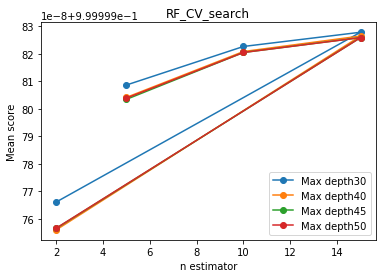

In [45]:
import matplotlib.pyplot as plt
class_plot(grid_rf, grid_1, 'RF_CV_search')

In [42]:
print (grid_rf.best_params_)
print (grid_rf.best_score_)

{'max_depth': 30, 'n_estimators': 15}
0.9999998278089582


In [46]:
# re-train the model with full training set
rf_best = grid_rf.best_estimator_
rf_best.fit(X_train, y_train)
pred_rf_test = rf_best.predict(X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    7.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished


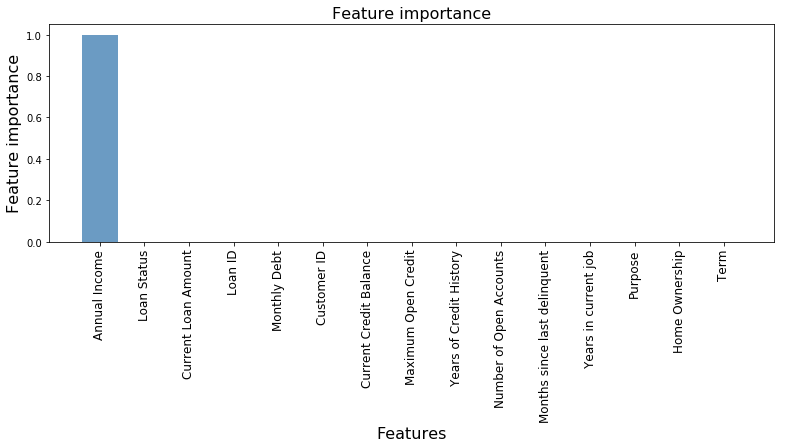

In [47]:
importance_rf_best = rf_best.feature_importances_
names_rf_best = X_train.columns.tolist()
df_importantce_rf_best = pd.DataFrame({'Feature':names_rf_best, 'Importance':importance_rf_best})
# plot feature importance
rank_importance_rf_best = df_importantce_rf_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_rf_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')